# Part 2: Analysis and Modelling
### *Creating a Hybrid Recommender System <br> using Content-based and Collaborative Filtering*


> #### by [Sebastian Einar Røkholt](https://www.linkedin.com/in/sebastianrokholt/)
>-------------------------------------------
> *January 2021*
----------------------------------------------------------------------------
<a id="top"></a> 
![Hybrid Recommender System Graphic](project-graphic.png)


### Project Index:
1. [GitHub Repo](http://url)
2. [cleanup.ipynb](http://url)
3. **analysis-and-modelling.ipynb**
4. [predict.ipynb](http://url)
    
### Analysis and Modelling Notebook Index:
1. [**Exploratory Data Analysis**](#analysis) <br>
    1.1       [*Exploring the Users Dataset*](#users)<br>
    1.2       [*Exploring the Movies and Ratings Datasets*](#movies-ratings)<br>
2. [***First Iteration:* Building a Hybrid Recommender with CBF and CF models**](#1st-iteration)<br>
    2.1       [*Splitting the Dataset*](#splitting-the-dataset)<br>
    2.2       [*Baseline Model*](#baseline)<br>
    2.3       [*Content-based Filtering*](#content-based)<br>
    2.4       [*Collaborative Filtering*](#collaborative)<br>
    2.5       [*Hybrid Recommender*](#hybrid)<br>
3. [**Feature Engineering**](#feature-engineering)<br>
    3.1 [*Adding release year*](#feature-engineering-1) <br>
    3.1 [*Adding the average age of movie fan*](#feature-engineering-2) <br>
4. [***Second Iteration:* Retraining CBF for the Improved Hybrid Recommender**](#2nd-iteration)<br>
    4.1       [*Improved Content-based Filtering*](#CBF-improved)<br>
    4.2       [*Improved Hybrid Recommender*](#hybrid-improved)<br>
5. [**Final Test and Evaluation**](#test)
------------

In [1]:
# ----------------------------------- NOTEBOOK SETUP --------------------------------------------------------- #
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import time
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import minmax_scale

# Setting plot style
plt.style.use('ggplot')

------
## <a id="analysis"></a>1) Exploratory Data Analysis 
[*Back to top*](#top)


This section will contain data exploration and visualizations in order to take a closer look at the cleaned datasets.<br>
Before I can start building and evaluating different models, I need to answer the following questions: <br>
&#9659; **What is the age and gender distribution among the users?** <br>
&#9659; **Which genres are the most common in the dataset?** <br>
&#9659; **What is the average rating, and how are the different rating scores (1 - 5) distributed across users and genres?** <br>
&#9659; **Has the average rating changed over time?**

In [2]:
# Loading the cleaned datasets
ratings_df = pd.read_csv("cleaned_data/rangering.csv")
movies_df = pd.read_csv("cleaned_data/film.csv")
users_df = pd.read_csv("cleaned_data/bruker.csv")

### <a id="users"></a>1.1) Exploring the Users Dataset

In [3]:
# Printing the users dataset
users_df.head()

,BrukerID,Kjonn,Alder,Jobb,Postkode
0,0,F,45,6,92103
1,1,M,50,16,55405-2546
2,2,M,18,20,44089
3,3,M,35,1,33304
4,4,M,35,6,48105


In [4]:
users_df.describe()

,BrukerID,Alder,Jobb
count,6040.000000,6040.000000,6040.000000
mean,3020.465894,29.894868,8.200828
std,1743.799216,12.484335,10.933051
min,0.000000,1.000000,0.000000
25%,1510.750000,25.000000,1.000000
50%,3020.500000,25.000000,6.000000
75%,4530.250000,35.000000,13.000000
max,6040.000000,56.000000,98.000000


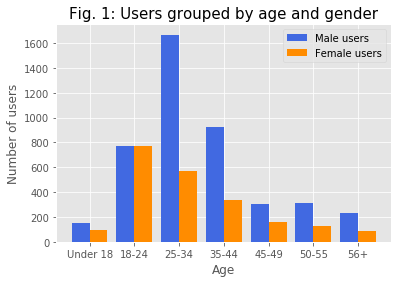

In [5]:
# Grouping user data into male and female age groups
user_age_gender_data = users_df[['Kjonn', 'Alder']]
female_user_ages = user_age_gender_data.loc[user_age_gender_data['Kjonn'] == 'F'].sort_values('Alder')
male_user_ages = user_age_gender_data.loc[user_age_gender_data['Kjonn'] == 'M'].sort_values('Alder')


def get_group_count(min_age, max_age, dataset):
    age_group = dataset.apply(lambda x: True if max_age > x['Alder'] > min_age else False, axis=1)
    count = len(age_group[age_group == True].index)
    return count


G1_male = get_group_count(0, 18, male_user_ages)
G2_male = get_group_count(17, 25, male_user_ages)
G3_male = get_group_count(24, 35, male_user_ages)
G4_male = get_group_count(34, 45, male_user_ages)
G5_male = get_group_count(44, 50, male_user_ages)
G6_male = get_group_count(49, 56, male_user_ages)
G7_male = get_group_count(55, 200, male_user_ages)

G1_female = get_group_count(0, 18, female_user_ages)
G2_female = get_group_count(17, 25, female_user_ages)
G3_female = get_group_count(24, 35, female_user_ages)
G4_female = get_group_count(34, 45, female_user_ages)
G5_female = get_group_count(44, 50, female_user_ages)
G6_female = get_group_count(49, 56, female_user_ages)
G7_female = get_group_count(55, 200, female_user_ages)

# Figure 1: Visualizing the userbase by plotting age and gender to a bar chart
labels = ['Under 18', '18-24', '25-34', '35-44', '45-49', '50-55', '56+']
men_grouped = [G1_male, G2_male, G3_male, G4_male, G5_male, G6_male, G7_male]
women_grouped = [G1_female, G2_male, G3_female, G4_female, G5_female, G6_female, G7_female]
x = np.arange(len(labels))  # the label locations
width = 0.40  # the width of the bars

fig1, ax1 = plt.subplots()
rects1 = ax1.bar(x - width/2, men_grouped, width, label='Male users', color='royalblue')
rects2 = ax1.bar(x + width/2, women_grouped, width, label='Female users', color='darkorange')

# Setting the labels for the bar chart
ax1.set_ylabel('Number of users', size=12)
ax1.set_xlabel('Age', size=12)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_title('Fig. 1: Users grouped by age and gender', size=15)
ax1.legend()

plt.show()

### <a id="movies-ratings"></a>1.2) Exploring the Movies and Ratings Datasets
[*Back to top*](#top)

In [6]:
# Printing the movies dataset
movies_df.head()

,FilmID,Tittel,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,Autumn in New York (2000),0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,1,"Vie est belle, La (Life is Rosey) (1987)",0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2,Defying Gravity (1997),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,3,Ruthless People (1986),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,Portraits Chinois (1996),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [7]:
movies_df.describe()

,FilmID,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000
mean,1973.687098,0.129539,0.072882,0.027041,0.040948,0.309039,0.054339,0.032707,0.412825,0.017512,0.011074,0.088334,0.029359,0.027041,0.121040,0.071079,0.126706,0.036827,0.017512
std,1142.105375,0.335839,0.259976,0.162224,0.198195,0.462157,0.226715,0.177891,0.492405,0.131187,0.104662,0.283816,0.168832,0.162224,0.326216,0.256990,0.332686,0.188362,0.131187
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,985.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1973.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2963.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3952.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
# Printing the ratings dataset
ratings_df.head()

,BrukerID,FilmID,Rangering,Tidstempel
0,0,1561,4,959441640
1,0,1540,3,959441640
2,0,88,3,959441640
3,0,620,4,959441640
4,0,3771,5,959442113


In [9]:
ratings_df.describe()

,BrukerID,FilmID,Rangering,Tidstempel
count,900117.000000,900117.000000,900117.000000,9.001170e+05
mean,2991.868675,1989.666242,3.581491,9.722407e+08
std,1736.208380,1126.359558,1.117162,1.214212e+07
min,0.000000,0.000000,1.000000,9.567039e+08
25%,1458.000000,1037.000000,3.000000,9.653030e+08
50%,2967.000000,1959.000000,4.000000,9.730170e+08
75%,4501.000000,2963.000000,4.000000,9.752206e+08
max,6040.000000,3952.000000,5.000000,1.046455e+09


The average rating across all users and movies is **3.58**. <br> 
My unconfirmed hypothesis for why this number is so high, is that most people watch movies that have been recommended to them, either by friends or by recommender systems. People also tend to do some research into which movie they want to watch, like watching a trailer, reading a review, etc. 

In [10]:
# Generating a new dataframe with rating score count (cols) vs genres (rows)
genres = list(movies_df)[2:]
merged = pd.merge(ratings_df, movies_df, on='FilmID')

cleaned = merged[['FilmID', 'BrukerID', 'Rangering', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy',
                  'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
                  'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'Tittel']]

movie_ratings = cleaned.sort_values('FilmID')
rating_scale = [1, 2, 3, 4, 5]

genres_rating_count = []
for genre in genres:
    for rating in rating_scale:
        genre_list = movie_ratings.loc[movie_ratings[genre] == 1]
        genre_rated_count = len(genre_list.loc[genre_list['Rangering'] == rating])
        genres_rating_count.append([genre, rating, genre_rated_count])


# Function for extracting the count of a specific rating of all genres
def get_rating_count(score):
    rating_count = []
    for count in genres_rating_count:
        if count[1] == score:
            rating_count.append(count[2])

    return rating_count


# Function for extracting the total nr of ratings for all genres
def get_total_rating_count():
    all_ratings = []
    totals = []
    for count in genres_rating_count:
        all_ratings.append(count[2])

    lower = 0
    for i in range(lower, len(all_ratings), 5):
        lower = i
        totals.append(sum(all_ratings[lower:lower+5]))

    return totals


genre_df = pd.DataFrame({'Genre': [genre for genre in genres], 'Rated 1': get_rating_count(1), 'Rated 2': get_rating_count(2),
              'Rated 3': get_rating_count(3), 'Rated 4': get_rating_count(4), 'Rated 5': get_rating_count(5),
              'Total nr of ratings': get_total_rating_count()})
genre_df["Average rating"] = (genre_df["Rated 1"] + (genre_df["Rated 2"] * 2) + (genre_df["Rated 3"] * 3) + 
                             (genre_df["Rated 4"] * 4) + (genre_df["Rated 5"] * 5)) / genre_df['Total nr of ratings']
genre_df

,Genre,Rated 1,Rated 2,Rated 3,Rated 4,Rated 5,Total nr of ratings,Average rating
0,Action,14884,28359,63691,77911,46969,231814,3.490574
1,Adventure,7675,15038,34070,39809,24009,120601,3.476273
2,Animation,1886,3264,9871,14258,9719,38998,3.683625
3,Children's,3500,4776,10932,11917,6554,37679,3.351628
4,Comedy,19410,36985,87148,111126,66128,320797,3.522377
5,Crime,2879,6726,17580,25579,18800,71564,3.708387
6,Documentary,246,425,1293,2723,2405,7092,3.932882
7,Drama,10917,26252,76415,118548,86967,319099,3.765894
8,Fantasy,2152,4269,9405,10513,6291,32630,3.445051
9,Film-Noir,243,764,2877,6186,6358,16428,4.074507


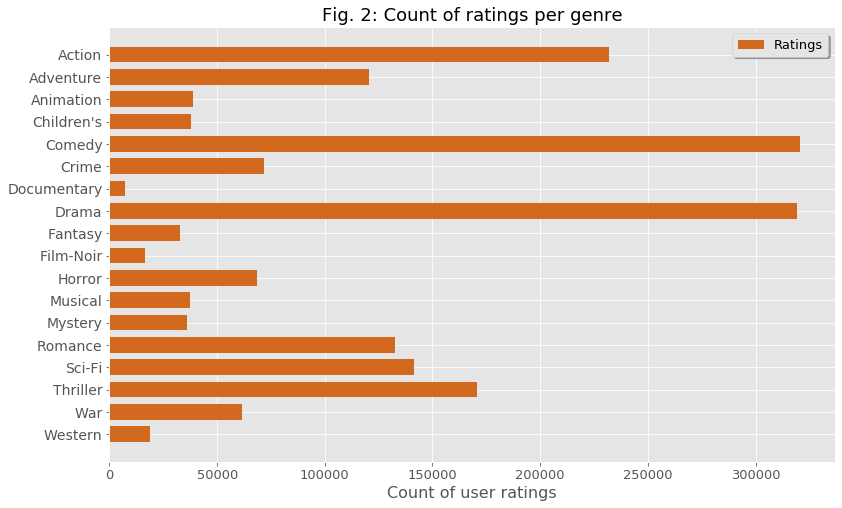

In [11]:
# Figure 2: Visualizing the number of ratings and rating scores for each genre
total_ratings = genre_df.iloc[:, 6].values.tolist()
fig2, ax2 = plt.subplots()
fig2_labels = [genre for genre in genres]
x = np.arange(len(fig2_labels))  # the label locations
width = 0.7  # the width of the bars
ax2.barh(x, total_ratings, width, label='Ratings', color='chocolate')

# Setting labels for bar chart
ax2.set_xlabel('Count of user ratings', size=16)
ax2.set_yticks(x)
ax2.set_yticklabels(fig2_labels, fontdict={'fontsize': 14})
ax2.set_title('Fig. 2: Count of ratings per genre', size=18)
ax2.invert_yaxis()  # Invert y axis so that the genres appear alphabetically
ax2.legend(shadow=0.4, prop={"size": 13})
plt.xticks(fontsize=13)

# Adjusting and displaying the graph
fig2.set_figheight(8)
fig2.set_figwidth(13)
plt.show()

As we can see from Figure 2, there are significantly more action, comedy and drama movies in the dataset than anything else. 
I therefore expect the average rating for these genres to converge around the average rating for all movies, while genres like Western, Documentary or Film-Noir might have somewhat higher or lower average ratings, perhaps making them a lot more or a lot less likely to be recommended than the rest. 

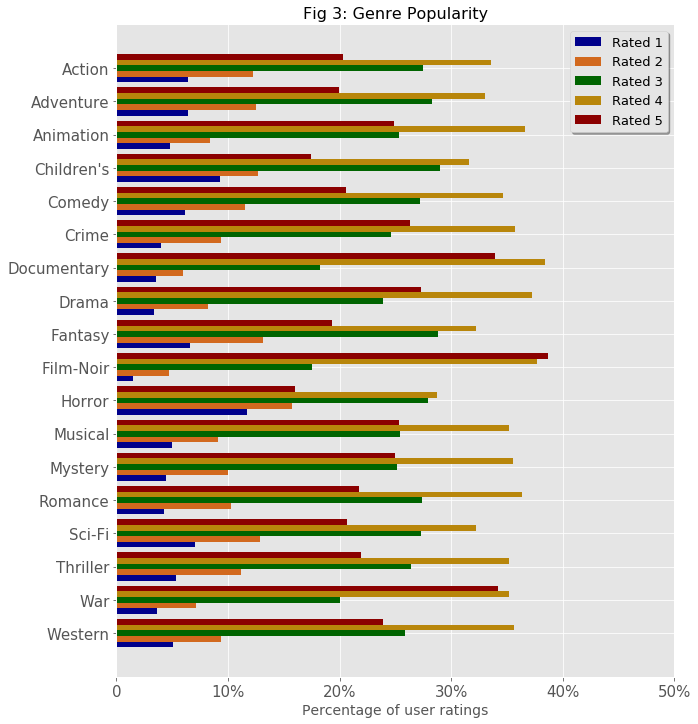

In [12]:
# Figure 3: Visualizing the ratings for each genre as a proportion of the total number of movies in that genre
# function for extracting the count of a specific rating of all genres
def get_rating_percentages(score):
    rated_count = genre_df.iloc[:, score].values.tolist()
    rating_percentages = []
    i = 0

    for total in total_ratings:
        percentage = (100 / total) * rated_count[i]
        i += 1
        rating_percentages.append(round(percentage, 1))

    return rating_percentages


genre_rating_percentage_data = {'Genre': [genre for genre in genres], 'Rated 1': get_rating_percentages(1),
                                'Rated 2': get_rating_percentages(2), 'Rated 3': get_rating_percentages(3),
                                'Rated 4': get_rating_percentages(4), 'Rated 5': get_rating_percentages(5),
                                'Total nr of ratings': get_total_rating_count()}
genre_rating_percent_df = pd.DataFrame(genre_rating_percentage_data)

rated_1_percentage = genre_rating_percent_df.iloc[:, 1].values.tolist()
rated_2_percentage = genre_rating_percent_df.iloc[:, 2].values.tolist()
rated_3_percentage = genre_rating_percent_df.iloc[:, 3].values.tolist()
rated_4_percentage = genre_rating_percent_df.iloc[:, 4].values.tolist()
rated_5_percentage = genre_rating_percent_df.iloc[:, 5].values.tolist()

fig3, ax3 = plt.subplots()
fig3_ylabels = [genre for genre in genres]
fig3_xlabels = ['0', '10%', '20%', '30%', '40%', '50%']
x = np.arange(len(fig3_ylabels))  # the label locations
width = 0.17  # the width of the bars

ax3.barh(x + width*2, rated_1_percentage, width, label='Rated 1', color='darkblue')
ax3.barh(x + width, rated_2_percentage, width, label='Rated 2', color='chocolate')
ax3.barh(x, rated_3_percentage, width, label='Rated 3', color='darkgreen')
ax3.barh(x - width, rated_4_percentage, width, label='Rated 4', color='darkgoldenrod')
ax3.barh(x - width*2, rated_5_percentage, width, label='Rated 5', color='darkred')

# Setting labels for bar chart
ax3.set_xlabel('Percentage of user ratings', size=14)
ax3.set_xticklabels(fig3_xlabels, fontdict={'fontsize': 15})
ax3.set_xlim(right=50)
ax3.set_yticks(x)
ax3.set_yticklabels(fig3_ylabels, fontdict={'fontsize': 15})
ax3.set_title('Fig 3: Genre Popularity', size=16)
ax3.invert_yaxis()  # Invert y axis so that the genres appear alphabetically
ax3.legend(shadow=0.4, prop={"size": 13})

# Adjusting and displaying the graph
fig3.set_figheight(12)
fig3.set_figwidth(10)
plt.show()

Figure 3 shows that a few genres, such as Film-Noir, Documentary and War, are significantly more liked in general than the rest. Since these genres consistently receive very high ratings, movies with these genre tags are very likely to be recommended.

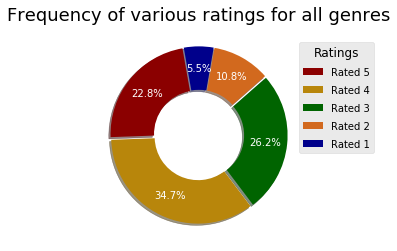

In [13]:
# Figure 4: Visualizing the proportional frequency of different rating scores for all genres
def get_rating_percentage_total(score):
    rated_count = genre_df.iloc[:, score].values.tolist()
    total_ratings_count = 0
    sum_ratings = 0

    for count in rated_count:
        sum_ratings += count

    for total in total_ratings:
        total_ratings_count += total

    return round((sum_ratings / total_ratings_count) * 100, 1)


ratings_data = [get_rating_percentage_total(5), get_rating_percentage_total(4), get_rating_percentage_total(3),
                get_rating_percentage_total(2), get_rating_percentage_total(1)]

# Plotting a pie (donut) chart for case distribution visualization
labels = ["Rated 5", "Rated 4", "Rated 3", "Rated 2", "Rated 1"]
fig4, ax4 = plt.subplots(subplot_kw=dict(aspect="equal"))
wedges, texts, autotext = ax4.pie(ratings_data, autopct='%1.1f%%', pctdistance=0.75, shadow=True,
                                  wedgeprops=dict(width=0.5), startangle=100, textprops=dict(color="w"),
                                  explode=(0.02, 0.02, 0.02, 0.02, 0.02), colors=['darkred', 'darkgoldenrod',
                                                                                  'darkgreen', 'chocolate', 'darkblue'])

ax4.legend(wedges, labels, loc="upper right", bbox_to_anchor=(1.0, 0.05, 0.33, 0.9), title='Ratings',
           title_fontsize='12', labelspacing=0.8)
ax4.set_title("Frequency of various ratings for all genres", size=18)

plt.show()

Figure 4 clearly shows that the MovieLens userbase rate movies highly on average. A score of 4 is very common, while 1's and 2's combined only take up 15% of the total ratings.

          Rangering
BrukerID           
0          3.296610
1          3.487179
2          3.600000
3          4.000000
4          3.891892


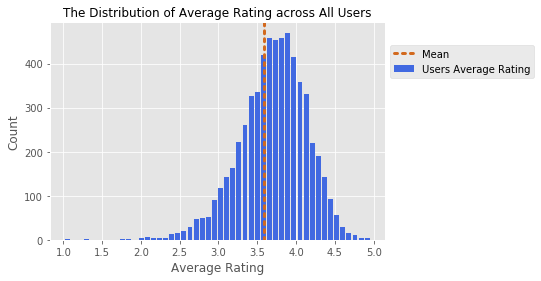

In [14]:
# Figure 5: Visualizing the distribution of average ratings for all users
users_avg_rating = pd.DataFrame(ratings_df.groupby('BrukerID')['Rangering'].mean())
print(users_avg_rating.head())

# Plotting a histogram over the average rating for all users
users_avg_rating = users_avg_rating['Rangering']
fig5, ax5 = plt.subplots()
n, bins, patches = ax5.hist(users_avg_rating, label='Users Average Rating',
                            stacked=True, color='royalblue', bins=50, rwidth=0.8)
# Set labels for histogram
ax5.set_xlabel('Average Rating', size=12)
ax5.set_ylabel('Count', size=12)
ax5.set_title('The Distribution of Average Rating across All Users', size=12)

# Add a line indicating the mean rating for all users
plt.axvline(ratings_df["Rangering"].mean(), color='chocolate', linestyle='dotted', dash_capstyle="round",
            linewidth=3, label="Mean")
ax5.legend(bbox_to_anchor=(1, 0.92))

plt.show()

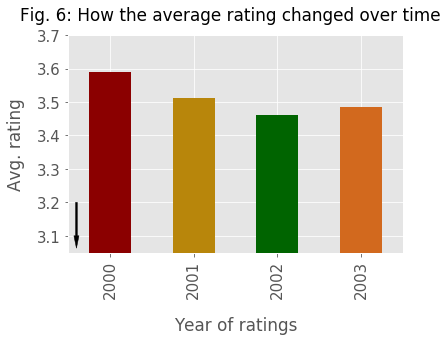

In [15]:
# Figure 6: Visualizing how the average rating has changed over time
def convert_timestamp_to_year(timestamp):
    date_string = time.ctime(timestamp)
    tokens = date_string.split(sep=" ")
    year = int(tokens[-1])
    return year


ratings_copy = ratings_df.copy()
ratings_copy['Rangeringsår'] = ratings_df["Tidstempel"].map(lambda timestamp: convert_timestamp_to_year(timestamp))
yearly_mean_rating = ratings_copy.groupby('Rangeringsår')['Rangering'].mean()

# Plotting a bar plot for average rating over time
plt.figure()
plt.rcParams.update({'font.size': 14})
yearly_mean_rating.plot(kind='bar', figsize=(10, 10), title="Fig. 6: How the average rating changed over time",
                        subplots=True, color=['darkred', 'darkgoldenrod', 'darkgreen', 'chocolate'],
                        ylim=(3.05, 3.7), fontsize=15, label='')
plt.xlabel(xlabel='Year of ratings', labelpad=18)
plt.ylabel(ylabel='Avg. rating', labelpad=12)

# Adding an arrow along the y axis to indicate that the axis continues to 0
# and that only an excerpt of the axis has been shown
plt.arrow(x=(-0.4), y=3.2, dx=0, dy=(-0.1), width=0.02, length_includes_head=False, head_length=0.037, head_width=0.06,
          color='black')

plt.show()

------
## <a id="1st-iteration"></a>2) *First Iteration:* Building a Hybrid Recommender System with CBF and CF models

[*Back to top*](#top)


### <a id="splitting-the-dataset"></a>2.1) Splitting the Dataset

In [16]:
# Splitting the ratings dataset into the feature set (X) and target labels (y)
X = ratings_df.drop(columns='Rangering')
y = ratings_df["Rangering"].values  # The movie ratings are the target variables we want to predict

# Preparing train, validation and test datasets.
# I have chosen a split ratio of 70%, 15%, 15%, because I want a somewhat large training set at the cost of a
# smaller validation and test set. I do not think that a smaller validation (or test) dataset will negatively
# impact the generalization ability of the chosen models, because I am only using rather simple ML models
# with few hyperparamaters.
X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, y, test_size=0.3, random_state=101)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5, random_state=101)

# Creating a complete training dataset with X_train and y_train
train_df = X_train.copy()
train_df["Rangering"] = y_train

train_df

,BrukerID,FilmID,Tidstempel,Rangering
708938,4341,1210,976573899,3
371257,1425,3192,970774826,4
845603,5565,2299,976239652,5
667558,3970,83,965770467,3
821518,5320,3843,976249576,4
...,...,...,...,...
661055,3915,1846,974698675,4
204614,32,884,974679433,4
476497,2357,101,975126955,4
214539,122,2098,974662091,4


<br><br>
### <a id="baseline"></a>2.2) The Baseline Model
In order to provide context for the evaluation of more advanced recommendation models, I will begin with constructing a very simple baseline model. I will use a popularity-based approach, where I calculate the average rating for each movie and simply predict that all users rate all movies after the movies' average rating. Even though this model provides no personalization, most users to in fact rate movies close to the average rating for the movies. I therefore expect that the RMSE for this model will prove to be somewhat challenging to beat.
<br><br>

In [17]:
# Creating a new dataframe with the average rating for each movie. 
# The "prediction" for the baseline "model" will actually just be these averages for each movie.
baseline_y_pred = pd.DataFrame(train_df.groupby('FilmID')['Rangering'].mean())

# The baseline model has not yet calculated an average for the movies (if any) with no ratings. 
# We therefore add these movies to the model with a predicted rating equal to the average rating 
# for all movies in the training dataset.
# ADD SOME CODE HERE!!

# Creating a dataframe for the validation data (y_true) in order to calculate RMSE of the baseline model
val_movies_dict = {'FilmID': X_val["FilmID"], 'Actual rating': y_val}  
val_movies_df = pd.DataFrame(val_movies_dict)

# Merging the training and validation datasets on the movie ID
y_pred_and_y_true = pd.merge(baseline_y_pred, val_movies_df, on='FilmID')
baseline_y_pred_vs_y_true = y_pred_and_y_true.rename(columns={"Rangering": "Predicted rating"})

baseline_y_pred_vs_y_true

,FilmID,Predicted rating,Actual rating
0,0,2.055556,1
1,0,2.055556,4
2,0,2.055556,3
3,0,2.055556,2
4,0,2.055556,2
...,...,...,...
134982,3952,2.353846,2
134983,3952,2.353846,1
134984,3952,2.353846,1
134985,3952,2.353846,3


In [18]:
# calculating RMSE for the baseline model
print("RMSE baseline model: ", sqrt(mean_squared_error(baseline_y_pred_vs_y_true["Predicted rating"], 
                                                       baseline_y_pred_vs_y_true["Actual rating"])))

RMSE baseline model:  0.981626106076701


<br><br>
### <a id="content-based"></a>2.3) Content Based Filtering
[*Back to top*](#top)

For the content-based filtering (CBF) models, I use the information about the users' movie preferences to predict recommendations. In particular, the CBF models use information about what each user has rated, what they rated, and the rated movie's genres to build an individual model for each user. The model then predicts ratings for all of the other movies in the dataset the user has not seen. 

I want to test a variety of different machine learning algorithms to establish which one is most beneficial for content-based recommendations on this dataset. Even though I suspect that the linear models will perform best, I will try out a few other types of machine learning algorithms as well for my own learning purposes.

The main advantage of CBF is that it takes individual user preferences into consideration. For movie recommendations, this is quite fitting, as we often have a few favourite movie genres, actors, directors, etc. that we enjoy more than others. Sadly, the movies dataset from MovieLens contains very few movie features, and content-based filtering models usually need a multitude of item features in order to accurately model user preferences. I will attempt to alleviate these problems with featue engineering in section 3. 

Another disadvantage with CBF is that these models struggle with very sparse matrices. I will likely encounter this exact issue, as most users only rate a few movies. In contrast to collaborative filtering, CBF models also have a disadvantage in that they don't consider similarities between users, since they only focus on items (content) and individual users. 

My hypothesis is that a content-based model which only uses the movie genre and user data will not be able to outperform the baseline model. To achieve this, CBF requires more features in the movies dataset. It will however be interesting to see how close I can get, and which model will perform best. The most successful model will be used in the hybrid recommender in chapter 2.5. 
<br>
<br>

In [19]:
# ----------- PREPARING TRAINING DATA ----------- #
# Adding the movie features (genre, release year) to the training dataset
content_train_df = pd.merge(train_df, movies_df, on='FilmID')
content_train_df.drop(columns=['Tidstempel', 'FilmID', 'Tittel'], inplace=True)  # Remove useless features

content_train_df

,BrukerID,Rangering,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,4341,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1242,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1056,5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,4381,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1134,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630076,4551,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
630077,455,4,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
630078,2305,4,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
630079,317,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [20]:
# Creating a list of lists with the target attribute (movie ratings), grouped by userID
y_grouped_by_user = content_train_df.groupby(["BrukerID"])
y_train_listed = []

for i, j in y_grouped_by_user:
    y_train_listed.append(j["Rangering"].values)  # Extract target feature (ratings) from sorted data
    
# Target attributes for the first user
y_train_listed[0]

array([4, 1, 4, 3, 5, 3, 4, 3, 5, 2, 4, 4, 4, 3, 4, 5, 2, 2, 5, 4, 3, 2,
       4, 4, 3, 2, 3, 3, 5, 4, 5, 1, 5, 3, 3, 2, 4, 3, 3, 4, 5, 3, 2, 4,
       3, 5, 1, 1, 4, 4, 3, 2, 1, 4, 4, 3, 3, 3, 4, 4, 3, 3, 1, 4, 4, 5,
       4, 3, 3, 4, 2, 3, 2, 2, 4, 4, 3, 5, 4, 2, 4, 3, 3, 3, 4, 2, 4, 5,
       4, 3, 3, 4, 3, 2, 3, 2, 3, 4, 3, 4, 4, 4, 5, 3, 3, 4, 3, 3, 4, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 3, 4, 4, 4, 3, 4, 3, 3, 5, 3, 4, 2, 3, 3,
       3, 3, 5, 2, 4, 3, 3, 4, 4, 3, 3, 5, 3, 2, 1, 3, 3, 3, 2, 3, 4, 3,
       2, 3, 3, 3, 4, 3, 4, 4, 2, 3, 3, 3, 2, 3, 4, 3], dtype=int64)

In [21]:
# Creating a list of dataframes with the feature set (movie info about genres and release year), grouped by userID
content_train_df.drop(columns='Rangering', inplace=True)
x_grouped_by_user = content_train_df.groupby(["BrukerID"])
x_train_listed = []

for user_id, group in x_grouped_by_user:
    x_train_listed.append(group.drop(columns='BrukerID'))
    
# The feature set for the first user
x_train_listed[0]

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
2824,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
9073,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
14756,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
18316,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
22117,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618870,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
618897,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
619528,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
625089,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [22]:
# Creating a new dataframe for the movies data
all_movies = movies_df.drop(columns=['Tittel', 'FilmID'])
all_movies

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3879,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3880,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3881,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [23]:
# ----------- PREPARING VALIDATION DATA ----------- #
# Creating a 2 dimensional matrix for the validation data in order to make it easier to calculate RMSE.

# Listing the user ID's in the same order as in the grouped dataframes
user_ids = []
for user_id, group in x_grouped_by_user:
    user_ids.append(user_id)
    
# Listing the movie IDs in the same order as in the movies dataset
movie_ids = movies_df["FilmID"].values

# Creating the matrix. Axis 1: User IDs, Axis 2: Movie IDs. Elements: True ratings from validation data
df_val = X_val.copy()
df_val["Rangering"] = y_val
validation_matrix = pd.DataFrame(index=user_ids, columns=movie_ids)  # Starting with an empty matrix
for array in df_val.to_records():  # Filling in the true ratings as elements
    user = array['BrukerID']
    movie = array['FilmID']
    true_rating = array['Rangering']
    validation_matrix.loc[user][movie] = true_rating
    
validation_matrix

,0,1,2,3,4,5,6,7,8,9,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# ----------- CREATING THE DIFFERENT CONTENT-BASED FILTERING MODELS ----------- #
# Assigning the different machine learning algorithms to be implemented in the models (incl. hyperparameters) to a dictionary
ml_algorithms = {"Linear regression": LinearRegression(), "Lasso": Lasso(), "KNN_7": KNeighborsRegressor(n_neighbors=7),
                 "RFR": RandomForestRegressor(), "SVR": SVR()}

# Saving lists that I later use to construct a dataframe containing the performances of the models
CBF_models_listed = []
RMSE_CBF_listed = []

# For every machine learning algorithm in the dictionary:
for name, ml_alg in ml_algorithms.items():
    # Create an empty list for predictions
    CBF_predictions = []

    # For each user in the training dataset:
    for i, x in enumerate(x_train_listed):
        # Fit a machine learning model
        ml_alg.fit(x_train_listed[i], y_train_listed[i])
        # Predict all the ratings for this user for all movies
        prediction = ml_alg.predict(all_movies)
        prediction = np.clip(prediction, 1, 5)  # Predictions must be minimum 1, maximum 5
        # Append all the predictions to the predictions list
        CBF_predictions.append(prediction)

    # Create a dataframe with the predictions
    df_predict = pd.DataFrame(CBF_predictions, index=user_ids, columns=movie_ids)

    # Create a dataframe with only the predictions for the movies-user combinations that appear in the validation set
    num_actual = validation_matrix.to_numpy().flatten()[validation_matrix.notna().to_numpy().flatten()]
    num_predict = df_predict.to_numpy().flatten()[validation_matrix.notna().to_numpy().flatten()]

    # Calculate the RMSE for the content-based filtering model and add the result to the lists
    RMSE_CBF_listed.append(sqrt(mean_squared_error(num_predict, num_actual)))
    CBF_models_listed.append(name)


# Printing the results
RMSE_CBF_df = pd.DataFrame({"Model": CBF_models_listed, "RMSE": RMSE_CBF_listed})
print("RMSE of different content-based filtering models without the year of release feature:")
RMSE_CBF_df

C:\Users\sebas\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)


RMSE of different content-based filtering models without the year of release feature


,Model,RMSE
0,Linear regression,1.071366
1,Lasso,1.037082
2,KNN_7,1.061543
3,RFR,1.080374
4,SVR,1.054499


As expected, the linear models performed better than the KNN classifier, though none of them outperformed the baseline model. Lasso had a sinificantly lower RMSE than the rest, so I will therefore use Lasso for the hybrid recommender in section 2.5. It will however be interesting to see how feature engineering will affect both the classifier and the best linear models. I wonder whether the difference in RMSE between the different models will change or remain the same.

In [25]:
# Running the best content-based filtering model so far
model = Lasso()
CBF_predictions = []

# For each user in the training dataset:
for i, j in enumerate(x_train_listed):
    model.fit(x_train_listed[i], y_train_listed[i])
    prediction = model.predict(all_movies)
    prediction = np.clip(prediction, 1, 5)
    CBF_predictions.append(prediction)

# Creating a dataframe for the predictions
CBF_model = pd.DataFrame(CBF_predictions, index=user_ids, columns=movie_ids)

C:\Users\sebas\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)


### <a id="collaborative"></a>2.4) Collaborative Filtering
[*Back to top*](#top)

I now continue to construct collaborative filtering (CF) models using the K-Nearest Neighbours algorithm, 
which I expect to compliment and outperform the content-based filtering models. I will be using a *user-based* collaborative filtering approach, such that user data (age, gender, location, etc.) will *not* have any influence on the recommendations. The user-based CF models will calculate predictions based on the preferences of the **most similar users** in regards to movie taste. The CF model therefore only needs to know which users have rated which movies, along with the value of each rating. The main disadvantage of user-based CF models, however, is that no contextual information about the rating, nor any information about the user or the items are considered. 

Similarity in movie preferences are calculated by using the relative difference in movie ratings, where each user's mean rating is subtracted from all of the users movie ratings. As seen in figure 5 in section 1.2, not all users have the same understanding of the rating scale. Some users tend to rate movies a lot higher or lower than others, despite having similar movie tastes. I measure user similary as the Pearson correlation coefficient subtracted from 1. After calculating similarities and distances between all users, a predicted rating for each movie is calculated by taking the average rating given by the K nearest neigbors (e.g. the k most similar users) who have rated the movie in question.

Since the dataset consists of ~6000 users and ~4000 movies, I expect that high values (30-100) for the K-hyperparameter will provide better predictions. However, I know that if I keep increasing the number of close users, the predicted rating will converge on the average rating, and thus perform identically to the baseline model. Increasing K will also result in a large increase in the time needed to train the model (and I'm not working on a particularly powerful PC). Seeing as higher K values are likely to give better predictions, I decided to calculate the predicted ratings with a weighted average (weight = 1/Pearson distance) to improve the predictions for the models with high values of K.

Similarly to the section on CBF I will train a variety of CF models, though these only vary in hyperparameters instead of algorithmically. I will then use the best performing CF model for the hybrid recommender in the next section.

In [26]:
# A quick look at the training data
train_df.head()

,BrukerID,FilmID,Tidstempel,Rangering
708938,4341,1210,976573899,3
371257,1425,3192,970774826,4
845603,5565,2299,976239652,5
667558,3970,83,965770467,3
821518,5320,3843,976249576,4


In [ ]:
# DATA PREPROCESSING: Calculating the Pearson Distance between all users in the training data
# Creating a 2D matrix (user ID vs movie ID) with the ratings as elements
user_matrix = train_df.pivot(index='BrukerID', columns='FilmID', values='Rangering')

# I subtract each user's average rating to magnify individual preferences
user_matrix = user_matrix.sub(user_matrix.mean(axis=1), axis=0)

# Replace NaN with 0.0, as this is now the "neutral" value
user_matrix = user_matrix.fillna(0.0)

In [27]:
# I calculate the Pearson Correlation between each user,
# and subtract this from 1 to get the Pearson Distance between users
user_dist_matrix = 1 - user_matrix.T.corr()
user_dist_matrix

BrukerID,0,1,2,3,4,5,6,7,8,9,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
BrukerID,,,,,,,,,,,,,,,,,,,,,
0,0.000000,1.008851,1.000000,0.870659,1.004774,1.005061,0.985787,0.993054,0.936473,1.000721,...,1.000000,0.993009,0.919575,1.008068,1.000520,1.004525,0.987334,1.019618,1.108225,0.992078
1,1.008851,0.000000,1.000000,1.000000,1.038525,1.215623,1.013271,0.981892,0.966971,0.972867,...,1.000000,1.014202,0.986063,0.993568,1.000000,1.000000,1.008252,1.011828,0.992498,1.027741
2,1.000000,1.000000,0.000000,1.000000,0.954233,1.000000,1.002765,0.967496,1.024260,0.956310,...,1.000000,0.939836,0.949094,0.938041,0.968789,0.914610,1.084354,1.000000,0.989900,1.029691
3,0.870659,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.911999,1.033222,...,1.000000,1.096116,1.000000,0.998262,1.000000,1.000000,1.001476,1.000000,1.000000,1.071963
4,1.004774,1.038525,0.954233,1.000000,0.000000,0.966535,1.079381,0.970525,0.924106,0.932877,...,0.994337,0.952138,0.979018,1.007612,1.046063,1.020158,0.936568,1.076701,1.008673,1.018350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,1.004525,1.000000,0.914610,1.000000,1.020158,1.000000,1.001341,0.931767,0.978402,0.988251,...,0.948502,0.975727,0.992479,0.984205,0.964859,0.000000,1.067465,1.000000,0.941595,1.008256
6037,0.987334,1.008252,1.084354,1.001476,0.936568,1.000000,1.003874,1.016693,0.986043,1.021241,...,1.000000,0.928262,1.027527,0.927628,1.105656,1.067465,0.000000,1.028313,1.000000,0.969143
6038,1.019618,1.011828,1.000000,1.000000,1.076701,1.000000,0.978866,1.000000,1.028991,0.961786,...,1.000000,0.981633,1.010349,0.987804,1.002550,1.000000,1.028313,0.000000,1.000000,0.998009


In [28]:
# MODELLING: Predicting ratings for every user with K Nearest Neighbours
# Models with a different number of neighbors
ml_algorithms = {'kNN-5': 5, 'kNN-10': 10, 'kNN-20': 20, 'kNN-30': 30, 'kNN-40': 40, "kNN-60": 60}

models_CF = []
RMSE_CF = []

# Training the models and predicting for the users and movies in the validation data
for name, num_neighbours in ml_algorithms.items():
    predictions = []

    # For every rating in the validation data
    for index, row in X_val.iterrows():
        # If the movie is in the training data
        if row["FilmID"] in X_train["FilmID"].unique():
            # Extract all user ID's for users who have rated the movie
            users_rated_movie = X_train.loc[X_train['FilmID'] == row['FilmID'], 'BrukerID']
            # Sort these users by similarity (Pearson distance)
            users_sorted = (user_dist_matrix.loc[row['BrukerID'], users_rated_movie].sort_values())
            # Select the nearest neighbours
            nearest_neighbours = users_sorted[:num_neighbours]
            # Extract the nearest neighbours' ratings data
            nn_data = train_df.loc[train_df['BrukerID'].isin(nearest_neighbours.index.to_list())]
            # Calculate the weighted average of the nearest neighbours' ratings
            nearest_neighbours_avg_rating = np.average(nn_data.loc[train_df['FilmID'] == row['FilmID'], 'Rangering'],
                                                       axis=0, weights=(1/nearest_neighbours))
        else:
            # There is a small chance that a few movies in the validation set might not appear in the training set.
            # I therefore predict that the user will rate these movies with the average rating for all movies
            nearest_neighbours_avg_rating = 4   # Must be changed!

        # Appending the prediction to the list of predictions
        if not np.isnan(nearest_neighbours_avg_rating):
            predictions.append(nearest_neighbours_avg_rating)
        else:
            predictions.append(3)

    models_CF.append(name)
    RMSE_CF.append(sqrt(mean_squared_error(y_val, predictions)))


# Displaying the results
RMSE_CF_dict = {"Model": models_CF, "RMSE": RMSE_CF}
RMSE_CF_df = pd.DataFrame(RMSE_CF_dict)
RMSE_CF_df

,Model,RMSE
0,kNN-5,1.013958
1,kNN-10,0.978301
2,kNN-20,0.962699
3,kNN-30,0.959578
4,kNN-40,0.958769
5,kNN-60,0.959030


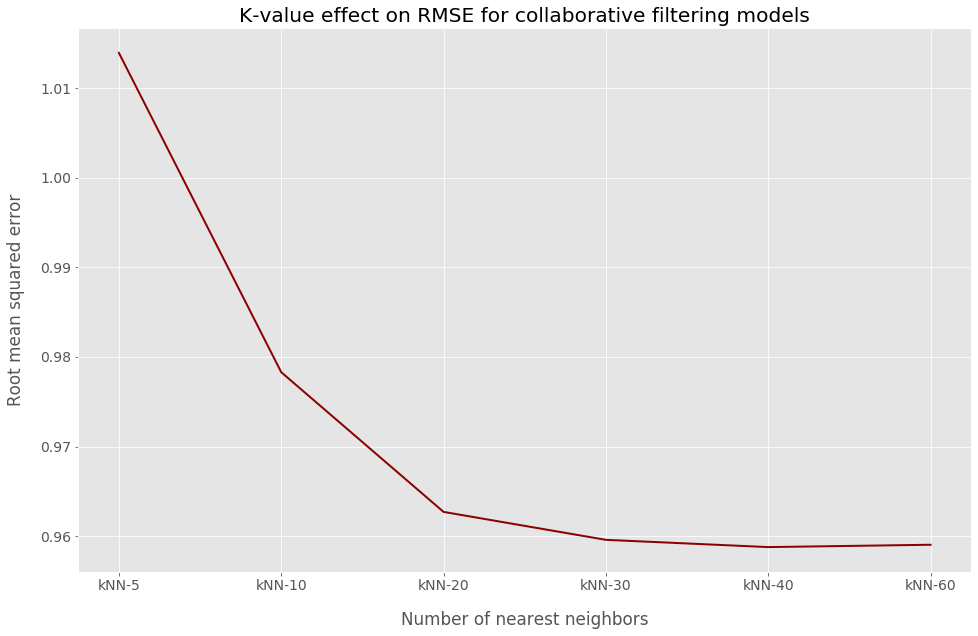

In [41]:
# Visualizing how the number of neighbors effect the root mean sqaured error
fig7, ax7 = plt.subplots()
ax7.plot(RMSE_CF_df.Model, RMSE_CF_df.RMSE, label="RMSE", color='darkred', linewidth=2)
plt.xlabel("Number of nearest neighbors", labelpad=18)
plt.ylabel("Root mean squared error", labelpad=15)
plt.title("K-value effect on RMSE for collaborative filtering models")
fig7.set_figheight(10)
fig7.set_figwidth(16)
plt.show()

The collaborative filtering models outperformed both the content-based and baseline models. With a K-value of 40, the model reached a RMSE of 0.9588. Higher K-values do not seem to lower RMSE any further, as RMSE increased slightly at K=60. I will now proceed with running the best model and storing the results for use in the hybrid recommender.

In [42]:
# Rerunning the best model so far (kNN-40) and storing the prediction results
best_CF_model = []
RMSE_best_CF = []

# Training the models and predicting for the users and movies in the validation data
CF_predictions = []

# For every movie in the validation data
for index, row in X_val.iterrows():
    # If that movie is in the training data
    if row["FilmID"] in X_train["FilmID"].unique():
        # Extract all user ID's for users who have rated the movie
        users_rated_movie = X_train.loc[X_train['FilmID'] == row['FilmID'], 'BrukerID']
        # Sort these users by similarity (Pearson distance)
        users_sorted = (user_dist_matrix.loc[row['BrukerID'], users_rated_movie].sort_values())
        # Select the nearest neighbours
        nearest_neighbours = users_sorted[:40]
        # Extract the nearest neighbours' ratings data
        nn_data = train_df.loc[train_df['BrukerID'].isin(nearest_neighbours.index.to_list())]
        # Calculate the weighted average of the nearest neighbours' ratings
        nearest_neighbours_avg_rating = np.average(nn_data.loc[train_df['FilmID'] == row['FilmID'], 'Rangering'],
                                                   axis=0, weights=(1/nearest_neighbours))
    else:
        # There is a small chance that a few movies in the validation set might not appear in the training set.
        # I therefore predict that the user will rate these movies with the average rating for all movies
        nearest_neighbours_avg_rating = 4   # Must be changed!

    # Appending the prediction to the list of predictions
    if not np.isnan(nearest_neighbours_avg_rating):
        CF_predictions.append(nearest_neighbours_avg_rating)
    else:
        CF_predictions.append(4)

### <a id="hybrid"></a>2.5) Hybrid Recommender
*Combining the Content-based and Collaborative filtering models to improve results*

[*Back to top*](#top)

This section will aim to combine both the best CBF and the CF models in an attempt to create a superior hybrid recommender. CF and CBF both have advantages and disadvantages, but their strengths and weaknesses complement each other so that a combination of the two might prove to outperform the CF model by itself.


In [43]:
# Extracting the validation prediction from the CBF dataframe containing all predictions
CBF_predictions = []
for index, row in X_val.iterrows():
    user_predictions = CBF_model.loc[row["BrukerID"], row["FilmID"]]
    CBF_predictions.append(user_predictions)
    

# Calculating the predictions for the different hybrid "models": different weighted averages of CF and CBF filtering
print("RMSE combined approach (Lasso and KNN-40):")
weighted_avgs = [(0.5, 0.5), (0.45, 0.55), (0.4, 0.6), (0.35, 0.65), (0.3, 0.7), (0.25, 0.75), (0.20, 0.80)]
  
for weight in weighted_avgs:
    combined_predictions = np.array([y_pred * weight[0] for y_pred in np.array(CBF_predictions)]) + np.array([y_pred * weight[1] for y_pred in np.array(CF_predictions)])
    print(f"RMSE for combined approach with CBF weighted {weight[0]} and CF weighted {weight[1]}: \n",
          sqrt(mean_squared_error(y_val, combined_predictions)), "\n")

RMSE combined approach (Lasso and KNN-40):
RMSE for combined approach with CBF weighted 0.5 and CF weighted 0.5: 
 0.9383490270968214 

RMSE for combined approach with CBF weighted 0.45 and CF weighted 0.55: 
 0.9347989553339932 

RMSE for combined approach with CBF weighted 0.4 and CF weighted 0.6: 
 0.9324893533664824 

RMSE for combined approach with CBF weighted 0.35 and CF weighted 0.65: 
 0.9314294489645997 

RMSE for combined approach with CBF weighted 0.3 and CF weighted 0.7: 
 0.9316235074661314 

RMSE for combined approach with CBF weighted 0.25 and CF weighted 0.75: 
 0.9330707464800498 

RMSE for combined approach with CBF weighted 0.2 and CF weighted 0.8: 
 0.9357653515804694 



------
## <a id="feature-engineering"></a>3) Feature Engineering 
[*Back to top*](#top)

The collaborative filtering model I am using for the hybrid recommender does not take any contextual information (such as time of rating) into account. This means that I cannot improve its performance by engineering any new features to the dataset. I could attempt to use a more elaborate method for calculating similarity, or use a completely different collaborative filtering approach such as multidimensional filtering, but that would be outside the scope of this project (at least for now).

However, the content-based filtering model predicts new ratings based on the user's movie preferences. By supplying the content-based model with more information about each user's preferences, I aim to improve the performance of the hybrid recommender. I will therefore engineer two new features for the movies dataset, and measure the impact these new features may have on the RMSE of the content-based filtering model and the hybrid recommendations.

In [44]:
# Re-loading clean datasets
ratings_df = pd.read_csv("cleaned_data/rangering.csv")
movies_df = pd.read_csv("cleaned_data/film.csv")
users_df = pd.read_csv("cleaned_data/bruker.csv")

### <a id="feature-engineering-1"></a>3.1) Adding release year to the movies dataset
Movies that are released around the same time often share similarities such as production style, tone, and cast. This might affect user's preferences, and the linear models in particular may learn the correlation between release year and rating for each user. It might also make it easier for KNN to cluster the rated movies and classify unrated movies released in a similar time period.

In [45]:
# Engineering feature nr. 1: Adding release year to movies dataset
for index, row in movies_df.iterrows():
    title = row[1]
    release_year = int(title[-5:-1])
    movies_df.loc[index, 'Utgivelsesår'] = release_year
    
# Printing the movies dataset again
movies_df.head()

,FilmID,Tittel,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Utgivelsesår
0,0,Autumn in New York (2000),0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,2000.0
1,1,"Vie est belle, La (Life is Rosey) (1987)",0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1987.0
2,2,Defying Gravity (1997),0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1997.0
3,3,Ruthless People (1986),0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1986.0
4,4,Portraits Chinois (1996),0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1996.0


### <a id="feature-engineering-2"></a>3.2) Adding the average age of movie fan to the movies dataset
Movies, like any product on the market, are designed and marketed to a specific type of audience. From the data analysis in section 1.1, I discovered that the userbase was quite varied across different ages, though not as much as one would expect in regards to the general population. There may yet be a significant correlation between the average age of common viewers and the rating for each movie, especially for children's movies or teenage dramas. However, movies may be designed for a rather narrow audience, but viewed (and rated) by a much larger one. I therefore want to find out whether additional data about the average age of the users who rated each movie highly will improve recommendations. I will call this new feature "Fan Average Age", or "FAA" for short.

In [63]:
# Feature engineering: Adding average viewer age to movies_df
ratings_users_merged = users_df.merge(ratings_df, on=['BrukerID'])
movie_fans = {movie_id: [] for movie_id in movies_df['FilmID']}

for index, row in ratings_users_merged.iterrows():
    rating = row['Rangering']
    movie_id = row['FilmID']
    user_age = row['Alder']

    if int(rating) > 3:  # If the rating the user gave was higher than 3, the user probably enjoyed the movie
        movie_fans[movie_id].append(user_age)


fan_avg_ages = []

for movie_id, ages in movie_fans.items():
    if len(ages) > 0:
        fan_avg_ages.append(np.mean(ages))
    else:
        fan_avg_ages.append(np.NaN)

movies_df['FAA'] = fan_avg_ages

print(f'There are {movies_df.isnull().sum().sum()} missing values for "FAA"')

# Mean imputation for missing values due to low ratings
movies_df['FAA'].fillna(29.894868, inplace=True)
movies_df.head()

There are 364 missing values for "FAA"


,FilmID,Tittel,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Utgivelsesår,FAA
0,0,Autumn in New York (2000),0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,2000.0,30.416667
1,1,"Vie est belle, La (Life is Rosey) (1987)",0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1987.0,29.833333
2,2,Defying Gravity (1997),0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1997.0,30.000000
3,3,Ruthless People (1986),0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1986.0,31.884259
4,4,Portraits Chinois (1996),0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1996.0,29.894868


There are 364 movies which don't have any ratings greater than 3, so I decided to handle this by imputing the mean user age. I don't think that this will negatively impact recommendations, as these movies wouldn't get recommended anyway. The machine learning algorithms should be able to recognize that the movies with missing FAA are unpopular movies, and might even lower the predicted rating for these movies.

In [96]:
# Writing the engineered movies dataframe to a .csv file
movies_df.to_csv('movies_feature_engineered.csv', index=False)

------
## <a id="2nd-iteration"></a>4) *Second Iteration:* Retraining the Content-based Filtering Model <br>for an Improved Hybrid Recommender
 [*Back to top*](#top)
 
 Engineering two new features may have improved the content-based filtering model. I will therefore retrain the three most promising CBF models and evaluate them on the validations dataset, before I implement the best one of them in the final hybrid recommender. 


In [64]:
# Redoing the train-val-test split with the same random state to get the same split
# Splitting the ratings dataset into the feature set (X) and target labels (y)
X = ratings_df.drop(columns='Rangering')
y = ratings_df["Rangering"].values  # The movie ratings are the target variables we want to predict

# Preparing train, validation and test datasets.
X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, y, test_size=0.3, random_state=101)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5, random_state=101)

# Creating a complete training dataset with X_train and y_train
train_df = X_train.copy()
train_df["Rangering"] = y_train

train_df

,BrukerID,FilmID,Tidstempel,Rangering
708938,4341,1210,976573899,3
371257,1425,3192,970774826,4
845603,5565,2299,976239652,5
667558,3970,83,965770467,3
821518,5320,3843,976249576,4
...,...,...,...,...
661055,3915,1846,974698675,4
204614,32,884,974679433,4
476497,2357,101,975126955,4
214539,122,2098,974662091,4


### <a id="CBF-improved"></a>4.1) Improved Content-based Filtering model

In [65]:
# For this next iteration of modelling, I will train the two most promising CBF models 
# on the dataset with three newly engineered features.

# ----------- PREPARING TRAINING DATA ----------- #
# Adding the movie features (genre, release year) to the training dataset
content_train_df = pd.merge(train_df, movies_df, on='FilmID')
content_train_df.drop(columns=['Tidstempel', 'FilmID', 'Tittel'], inplace=True)  # Remove useless features

# Creating a list of lists with the target attribute (movie ratings), grouped by userID
y_grouped_by_user = content_train_df.groupby(["BrukerID"])
y_train_listed = []

for i, j in y_grouped_by_user:
    y_train_listed.append(j["Rangering"].values)  # Extract target feature (ratings) from sorted data
    
# Target attributes for the first user
y_train_listed[0]

# Creating a list of dataframes with the feature set (movie info about genres and release year), grouped by userID
content_train_df.drop(columns='Rangering', inplace=True)
x_grouped_by_user = content_train_df.groupby(["BrukerID"])
x_train_listed = []

for user_id, group in x_grouped_by_user:
    x_train_listed.append(group.drop(columns='BrukerID'))
    
    
# Creating a new dataframe for the movies data
all_movies = movies_df.drop(columns=['Tittel', 'FilmID'])
all_movies


# ----------- PREPARING VALIDATION DATA ----------- #
# Creating a 2 dimensional matrix for the validation data in order to make it easier to calculate RMSE.

# Listing the user ID's in the same order as in the grouped dataframes
user_ids = []
for user_id, group in x_grouped_by_user:
    user_ids.append(user_id)
    
# Listing the movie IDs in the same order as in the movies dataset
movie_ids = movies_df["FilmID"].values

# Creating the matrix. Axis 1: User IDs, Axis 2: Movie IDs. Elements: True ratings from validation data
df_val = X_val.copy()
df_val["Rangering"] = y_val
validation_matrix = pd.DataFrame(index=user_ids, columns=movie_ids)  # Starting with an empty matrix
for array in df_val.to_records():  # Filling in the true ratings as elements
    user = array['BrukerID']
    movie = array['FilmID']
    true_rating = array['Rangering']
    validation_matrix.loc[user][movie] = true_rating
    

In [68]:
# ----------- CREATING THE DIFFERENT IMPROVED CONTENT-BASED FILTERING MODELS ----------- #
ml_algorithms = {"Lasso": Lasso(), "KNN_7": KNeighborsRegressor(n_neighbors=7), "SVR": SVR()}

# Saving lists that I later use to construct a dataframe containing the performances of the models
improved_models_listed = []
improved_models_RMSE = []

# For every machine learning algorithm in the dictionary:
for name, ml_alg in ml_algorithms.items():
    # Create an empty list for predictions
    CBF_predictions = []

    # For each user in the training dataset:
    for i, x in enumerate(x_train_listed):
        # Fit a machine learning model with the year of release feature
        ml_alg.fit(x_train_listed[i], y_train_listed[i])
        # Predict all the ratings for this user for all movies
        prediction = ml_alg.predict(all_movies)
        prediction = np.clip(prediction, 1, 5)  # Predictions must be minimum 1, maximum 5
        # Append all the predictions to the predictions list
        CBF_predictions.append(prediction)

    # Create a dataframe with the predictions
    CBF_y_pred_df = pd.DataFrame(CBF_predictions, index=user_ids, columns=movie_ids)

    # Create a dataframe with only the predictions for the movies-user combinations that appear in the validation set
    num_actual = validation_matrix.to_numpy().flatten()[validation_matrix.notna().to_numpy().flatten()]
    num_predict = CBF_y_pred_df.to_numpy().flatten()[validation_matrix.notna().to_numpy().flatten()]

    # Calculate the RMSE for the content-based filtering model and add the result to the lists
    improved_models_RMSE.append(sqrt(mean_squared_error(num_predict, num_actual)))
    improved_models_listed.append(name)


# Printing the results
RMSE_content_df_improved = pd.DataFrame({"Model": improved_models_listed, "RMSE": improved_models_RMSE})
print("RMSE of different content-based filtering models, including the year of release feature")
RMSE_content_df_improved

C:\Users\sebas\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)


RMSE of different content-based filtering models, including the year of release feature


,Model,RMSE
0,Lasso,1.020758
1,KNN_7,1.040054
2,SVR,1.070242


Previously, Lasso performed with an RMSE of 1.037. It still outperforms both KNN and SVR after training with new features, with an RMSE reduced by 0.016242. The performance increase is not exactly astounding, but still significant enough to confirm that the feature engineering was successful.

In [72]:
# Running the best improved content-based filtering model
model = Lasso()
CBF_improved_predictions = []

# For each user in the training dataset:
for i, j in enumerate(x_train_listed):
    model.fit(x_train_listed[i], y_train_listed[i])
    prediction = model.predict(all_movies)
    prediction = np.clip(prediction, 1, 5)
    CBF_improved_predictions.append(prediction)

# Creating a dataframe for the predictions
CBF_improved_model = pd.DataFrame(CBF_improved_predictions, index=user_ids, columns=movie_ids)

# Creating a dataframe with only the predictions for the movies-user combinations that appear in the validation set
num_actual = validation_matrix.to_numpy().flatten()[validation_matrix.notna().to_numpy().flatten()]
num_predict = CBF_improved_model.to_numpy().flatten()[validation_matrix.notna().to_numpy().flatten()]
print("RMSE of best content-based filtering model:", sqrt(mean_squared_error(num_predict, num_actual)))

# Saving the best CBF model's prediction to disk for later use
CBF_improved_model.to_pickle("./CBF_model.pkl")

C:\Users\sebas\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)


RMSE of best content-based filtering model: 1.0207579360879961


### <a id="hybrid-improved"></a>4.2) Improved Hybrid Recommender
I will now implement the improved CBF model in a new hybrid recommender, and test different weight combinations against the validation set.

In [77]:
# Extracting the validation prediction from the improved content dataframe containing all predictions
CBF_y_pred = []
for index, row in X_val.iterrows():
    user_predictions = CBF_improved_model.loc[row["BrukerID"], row["FilmID"]]
    CBF_y_pred.append(user_predictions)

# Calculating the predictions for the different hybrid "models": 
# different weighted averages of CF and improved CBF filtering
print("RMSE combined approach (Lasso and KNN-40):")
weighted_avgs = [(0.5, 0.5), (0.45, 0.55), (0.4, 0.6), (0.35, 0.65), (0.3, 0.7), (0.25, 0.75), (0.20, 0.80)]
for weight in weighted_avgs:
    combined_predictions = ((np.array(CBF_y_pred) * weight[0]) + (np.array(CF_predictions)) * weight[1])
    print(f"RMSE for combined approach with CBF weighted {weight[0]} and CF weighted {weight[1]}: \n",
          sqrt(mean_squared_error(y_val, combined_predictions)), "\n")

RMSE combined approach (Lasso and KNN-40):
RMSE for combined approach with CBF weighted 0.5 and CF weighted 0.5: 
 0.9310363505982111 

RMSE for combined approach with CBF weighted 0.45 and CF weighted 0.55: 
 0.9283464888895532 

RMSE for combined approach with CBF weighted 0.4 and CF weighted 0.6: 
 0.9268766505281787 

RMSE for combined approach with CBF weighted 0.35 and CF weighted 0.65: 
 0.926632641189354 

RMSE for combined approach with CBF weighted 0.3 and CF weighted 0.7: 
 0.9276154282369545 

RMSE for combined approach with CBF weighted 0.25 and CF weighted 0.75: 
 0.9298211216418713 

RMSE for combined approach with CBF weighted 0.2 and CF weighted 0.8: 
 0.9332410505126286 



------
## <a id="test"></a>5) Final Test and Evaluation

[*Back to top*](#top)

Finally, I will test the generalization ability of the improved hybrid recommender by making predictions on the test dataset. I will weight the CBF model 0.35 and the CF model 0.65, as this combination has proved to be the most optimal from the test made on the validation set.

In [82]:
# Building the hybrid recommender: Collaborative Filtering
CF_predictions_test = []
for index, row in X_test.iterrows():
    if row["FilmID"] in X_train["FilmID"].unique():
        users_rated_movie = X_train.loc[X_train['FilmID'] == row['FilmID'], 'BrukerID']
        users_sorted = (user_dist_matrix.loc[row['BrukerID'], users_rated_movie].sort_values())
        n_neighbours = users_sorted[:40]
        nn_data = train_df.loc[train_df['BrukerID'].isin(n_neighbours.index.to_list())]
        nearest_neighbours_avg_rating = np.average(nn_data.loc[train_df['FilmID'] == row['FilmID'], 'Rangering'],
                                                   axis=0, weights=(1/n_neighbours))
    else:
        nearest_neighbours_avg_rating = train_df["Rangering"].mean()

    # appending the prediction to the list
    if not np.isnan(nearest_neighbours_avg_rating):
        CF_predictions_test.append(nearest_neighbours_avg_rating)
    else:
        CF_predictions_test.append(4)

print("RMSE KNN_40:", sqrt(mean_squared_error(y_test, CF_predictions_test)))

RMSE KNN_40: 0.958015760014762


In [92]:
# Building the hybrid recommender: Content-Based filtering
# Extracting the predictions for the movies and users in the test data
# from the CBF dataframe (which contains predictions for all movies and all users)
CBF_predictions_test = []
for index, row in X_test.iterrows():
    user_predictions = CBF_improved_model.loc[row["BrukerID"], row["FilmID"]]
    CBF_predictions_test.append(user_predictions)

print("RMSE Lasso:", sqrt(mean_squared_error(y_test, CBF_predictions_test)))

RMSE Lasso: 1.019278388038111


In [95]:
# Calculating the hybrid recommendations
hybrid_predictions_test = (np.array([y_pred * 0.35 for y_pred in np.array(CBF_predictions_test)]) 
                           + np.array([y_pred * 0.65 for y_pred in np.array(CF_predictions_test)]))

# Displaying the test results from training the Hybrid Recommender on test data
print(f"RMSE hybrid recommendations (test data): {sqrt(mean_squared_error(y_test, hybrid_predictions_test))} ")

RMSE hybrid recommendations (test data): 0.9254351615504374 


------------
The hybrid recommender model can be expected to perform predictions with a RMSE of 0.925 on test data. The baseline model performed with an RMSE of 0.982, so there is a considerable improvement in recommedations after implementing measures for specific user preferences grouping users with similar tastes. 

The hybrid recommender requires two new features to be engineered and added to the dataset before training the models. The engineered features are each movie's release year and average fan age.

There are multiple unexplored possibilities for me to further improve the hybrid recommender system. A few of them are listed below: 
   1. Calculating the average fan age as a quantile of the ratings for each movie
   2. Using more advanced similarity metrics in collaborative filtering, such as a genetic- or [memetic-based  similarity metrics](https://www.ibm.com/support/knowledgecenter/SSHGWL_1.2.3/analyze-data/markd-jupyter.html).
   3. Using more advanced collaborative filtering models, such as [multidimensional CF](https://www.researchgate.net/publication/275026753_A_Multidimensional_Collaborative_Filtering_Fusion_Approach_with_Dimensionality_Reduction)
   4. Scraping more information about each movie from the web

In the future, I will hopefully make time to implement the hybrid recommender system in a simple website application in order to have fully explored all aspects of the data science process. For now, I will use the hybrid recommender to [predict ratings for all users and all movies](https://github.com/SebastianRokholt/Hybrid-Recommender-System), storing the output to a file.

[*Back to top*](#top)